# Notebook 11: CatBoost Model - Statistical
## Stanford TECH 27 Final Project

This notebook trains a CatBoost model using ONLY statistical features from sequences.
No timestep-specific or temporal features are used, which would make the model only applicable to constant discharge scenarios.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# CatBoost
from catboost import CatBoostRegressor, Pool

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Processed Data from Notebook 05

In [2]:
# Define paths
OUTPUT_DIR = Path('processed_data')

# Load sequential data
print("Loading sequential data from notebook 05...")
with open(OUTPUT_DIR / 'final_lstm_ml_datasets.pkl', 'rb') as f:
    data = pickle.load(f)

X_train_seq = data['X_train']
X_val_seq = data['X_val']
X_test_seq = data['X_test']
y_train = data['y_train']
y_val = data['y_val']
y_test = data['y_test']
feature_names_original = data['feature_names']

# Print original features to identify what to remove
print("\nOriginal features:")
for i, name in enumerate(feature_names_original):
    print(f"  {i}: {name}")

# Remove features that would not be available in real-world scenarios
# 1. SOC lag features (data leakage): 34, 37, 40
# 2. Temporal features (assume constant discharge): 30 (time_normalized), 31 (time_since_start)
leaking_features = [34, 37, 40]
temporal_features = [30, 31]
features_to_remove = leaking_features + temporal_features

print(f"\nRemoving data leakage features: {[feature_names_original[i] for i in leaking_features]}")
print(f"Removing temporal features: {[feature_names_original[i] for i in temporal_features]}")
print("(Temporal features assume constant discharge, not realistic for real-world use)")

# Create mask for features to keep
keep_features = [i for i in range(X_train_seq.shape[2]) if i not in features_to_remove]
kept_feature_names = [feature_names_original[i] for i in keep_features]

X_train_seq = X_train_seq[:, :, keep_features]
X_val_seq = X_val_seq[:, :, keep_features]
X_test_seq = X_test_seq[:, :, keep_features]

print(f"\nData shapes:")
print(f"X_train: {X_train_seq.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val_seq.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test_seq.shape}, y_test: {y_test.shape}")

sequence_length = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]
print(f"\nSequence length: {sequence_length}")
print(f"Number of features: {n_features}")

Loading sequential data from notebook 05...

Original features:
  0: voltage
  1: current
  2: temperature
  3: Current_load
  4: Voltage_load
  5: power
  6: abs_current
  7: voltage_current_ratio
  8: energy
  9: voltage_change
  10: current_change
  11: temperature_change
  12: power_change
  13: voltage_rolling_mean_5
  14: current_rolling_mean_5
  15: temperature_rolling_mean_5
  16: voltage_rolling_std_5
  17: current_rolling_std_5
  18: voltage_rolling_mean_10
  19: current_rolling_mean_10
  20: temperature_rolling_mean_10
  21: voltage_rolling_std_10
  22: current_rolling_std_10
  23: voltage_rolling_mean_20
  24: current_rolling_mean_20
  25: temperature_rolling_mean_20
  26: voltage_rolling_std_20
  27: current_rolling_std_20
  28: cumulative_discharge
  29: cumulative_energy
  30: time_normalized
  31: time_since_start
  32: voltage_lag_1
  33: current_lag_1
  34: SOC_lag_1
  35: voltage_lag_3
  36: current_lag_3
  37: SOC_lag_3
  38: voltage_lag_5
  39: current_lag_5
  40: 

## 3. Prepare Data for CatBoost

CatBoost doesn't handle 3D sequential data directly, so we'll flatten the sequences.

In [3]:
# Flatten the sequential data for tree-based models
def flatten_sequences(X_seq):
    """
    Convert 3D sequential data to 2D using ONLY statistical features.
    This avoids timestep-specific features that assume constant discharge patterns.
    """
    n_samples = X_seq.shape[0]
    n_timesteps = X_seq.shape[1]
    n_features = X_seq.shape[2]
    
    # DO NOT flatten the sequences directly - this creates timestep-specific features
    # Instead, ONLY use statistical features that summarize the sequence
    
    stats_features = []
    for feat_idx in range(n_features):
        feat_seq = X_seq[:, :, feat_idx]
        
        # Calculate statistics across the sequence
        # These are invariant to the specific position in discharge cycle
        stats_features.append(np.mean(feat_seq, axis=1).reshape(-1, 1))
        stats_features.append(np.std(feat_seq, axis=1).reshape(-1, 1))
        stats_features.append(np.min(feat_seq, axis=1).reshape(-1, 1))
        stats_features.append(np.max(feat_seq, axis=1).reshape(-1, 1))
        
        # Additional robust statistics
        stats_features.append(np.median(feat_seq, axis=1).reshape(-1, 1))
        stats_features.append(np.percentile(feat_seq, 25, axis=1).reshape(-1, 1))  # Q1
        stats_features.append(np.percentile(feat_seq, 75, axis=1).reshape(-1, 1))  # Q3
        
        # Rate of change (last - first) - still useful as it shows trend
        rate_change = (feat_seq[:, -1] - feat_seq[:, 0]).reshape(-1, 1)
        stats_features.append(rate_change)
        
        # Average rate of change
        avg_rate = np.mean(np.diff(feat_seq, axis=1), axis=1).reshape(-1, 1)
        stats_features.append(avg_rate)
    
    # Combine all features - NO timestep-specific features
    X_combined = np.hstack(stats_features)
    
    return X_combined

print("Creating statistical features from sequences...")

X_train_flat = flatten_sequences(X_train_seq)
X_val_flat = flatten_sequences(X_val_seq)
X_test_flat = flatten_sequences(X_test_seq)

print(f"\nFlattened data shapes (statistical features only):")
print(f"X_train_flat: {X_train_flat.shape}")
print(f"X_val_flat: {X_val_flat.shape}")
print(f"X_test_flat: {X_test_flat.shape}")

# Calculate number of features per original feature
stats_per_feature = 9  # mean, std, min, max, median, Q1, Q3, rate, avg_rate
print(f"\nFeatures breakdown:")
print(f"  Original features: {n_features}")
print(f"  Statistics per feature: {stats_per_feature}")
print(f"  Total features: {X_train_flat.shape[1]} (should be {n_features * stats_per_feature})")

Creating statistical features from sequences...

Flattened data shapes (statistical features only):
X_train_flat: (326521, 360)
X_val_flat: (101551, 360)
X_test_flat: (113381, 360)

Features breakdown:
  Original features: 40
  Statistics per feature: 9
  Total features: 360 (should be 360)


## 4. Train CatBoost Model

In [4]:
# Initialize CatBoost with parameters optimized for battery data
catboost_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    l2_leaf_reg=3.0,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    use_best_model=True,
    verbose=100,
    thread_count=-1,
    # CatBoost specific parameters
    bootstrap_type='Bernoulli',
    subsample=0.8,
    min_data_in_leaf=50,
    max_leaves=31,
    # Save training info to OUTPUT_DIR with different name to avoid overwriting
    train_dir=str(OUTPUT_DIR / 'catboost_notime_info')
)

print("Training CatBoost model (no temporal features)...")
print("This may take a few minutes...\n")

# Create Pool objects for efficient training
train_pool = Pool(X_train_flat, y_train)
val_pool = Pool(X_val_flat, y_val)

# Train the model
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False
)

print(f"\nBest iteration: {catboost_model.best_iteration_}")
print(f"Best score: {catboost_model.best_score_['validation']['RMSE']:.4f}")

Training CatBoost model (no temporal features)...
This may take a few minutes...

0:	learn: 0.2172755	test: 0.2060109	best: 0.2060109 (0)	total: 178ms	remaining: 2m 57s
100:	learn: 0.0215800	test: 0.0547829	best: 0.0547829 (100)	total: 5.45s	remaining: 48.5s
200:	learn: 0.0146027	test: 0.0540993	best: 0.0540902 (195)	total: 10.2s	remaining: 40.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.05409019071
bestIteration = 195

Shrink model to first 196 iterations.

Best iteration: 195
Best score: 0.0541


## 5. Make Predictions

In [5]:
# Make predictions
print("Making predictions...")
y_train_pred = catboost_model.predict(X_train_flat)
y_val_pred = catboost_model.predict(X_val_flat)
y_test_pred = catboost_model.predict(X_test_flat)

# Clip predictions to [0, 1] range
y_train_pred = np.clip(y_train_pred, 0, 1)
y_val_pred = np.clip(y_val_pred, 0, 1)
y_test_pred = np.clip(y_test_pred, 0, 1)

print("Predictions complete.")

Making predictions...
Predictions complete.


## 6. Evaluate Model Performance

In [6]:
def evaluate_model(y_true, y_pred, dataset_name):
    """Calculate and display evaluation metrics"""
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Convert to percentage SOC
    mae_percent = mae * 100
    rmse_percent = rmse * 100
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae_percent:.3f}% SOC")
    print(f"  RMSE: {rmse_percent:.3f}% SOC")
    
    return {'r2': r2, 'mae': mae_percent, 'rmse': rmse_percent}

# Evaluate on all sets
train_metrics = evaluate_model(y_train, y_train_pred, "Training")
val_metrics = evaluate_model(y_val, y_val_pred, "Validation")
test_metrics = evaluate_model(y_test, y_test_pred, "Test")


Training Set Performance:
  R² Score: 0.9958
  MAE: 1.000% SOC
  RMSE: 1.480% SOC

Validation Set Performance:
  R² Score: 0.9366
  MAE: 4.116% SOC
  RMSE: 5.409% SOC

Test Set Performance:
  R² Score: 0.9382
  MAE: 4.034% SOC
  RMSE: 5.520% SOC


## 7. Feature Importance Analysis

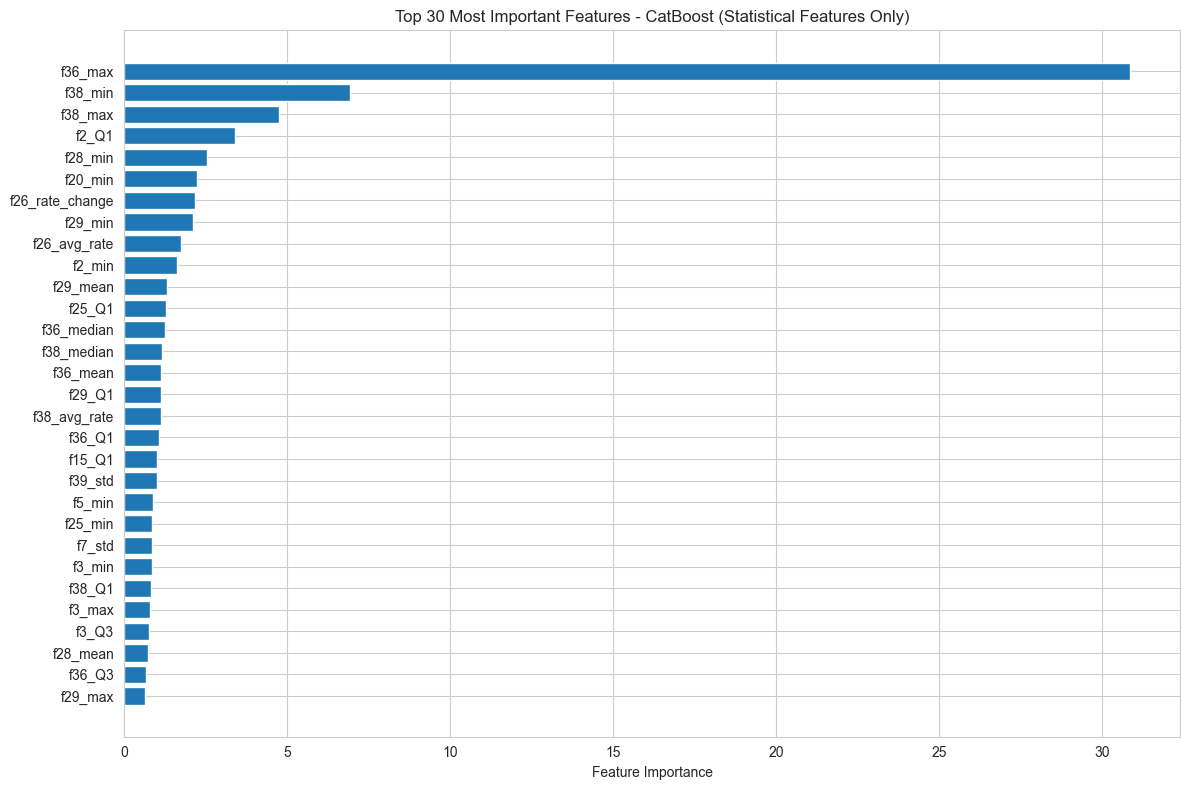


Top 10 Most Important Features:
        feature  importance
        f36_max   30.837100
        f38_min    6.916947
        f38_max    4.742573
          f2_Q1    3.404115
        f28_min    2.524355
        f20_min    2.237081
f26_rate_change    2.185918
        f29_min    2.098638
   f26_avg_rate    1.748813
         f2_min    1.617331

Feature interpretation (top 10):
  f36_max: max of voltage_vs_mean
  f38_min: min of voltage_percentile
  f38_max: max of voltage_percentile
  f2_Q1: Q1 of temperature
  f28_min: min of cumulative_discharge
  f20_min: min of temperature_rolling_mean_10
  f26_rate_change: rate_change of voltage_rolling_std_20
  f29_min: min of cumulative_energy
  f26_avg_rate: avg_rate of voltage_rolling_std_20
  f2_min: min of temperature


In [7]:
# Get feature importances
feature_importance = catboost_model.get_feature_importance()

# Create feature names for statistical features only
feature_names = []
stats = ['mean', 'std', 'min', 'max', 'median', 'Q1', 'Q3', 'rate_change', 'avg_rate']

for f in range(n_features):
    for stat in stats:
        feature_names.append(f"f{f}_{stat}")

# Sort features by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 30 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(30)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Feature Importance')
plt.title('Top 30 Most Important Features - CatBoost (Statistical Features Only)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))

# Also print what the top features actually represent
print("\nFeature interpretation (top 10):")
for idx, row in importance_df.head(10).iterrows():
    feat_name = row['feature']
    # Parse f{feature}_{stat}
    parts = feat_name.split('_', 1)
    feat_idx = int(parts[0][1:])
    stat = parts[1]
    actual_name = kept_feature_names[feat_idx] if feat_idx < len(kept_feature_names) else f"feature_{feat_idx}"
    print(f"  {feat_name}: {stat} of {actual_name}")

## 8. Visualization of Results

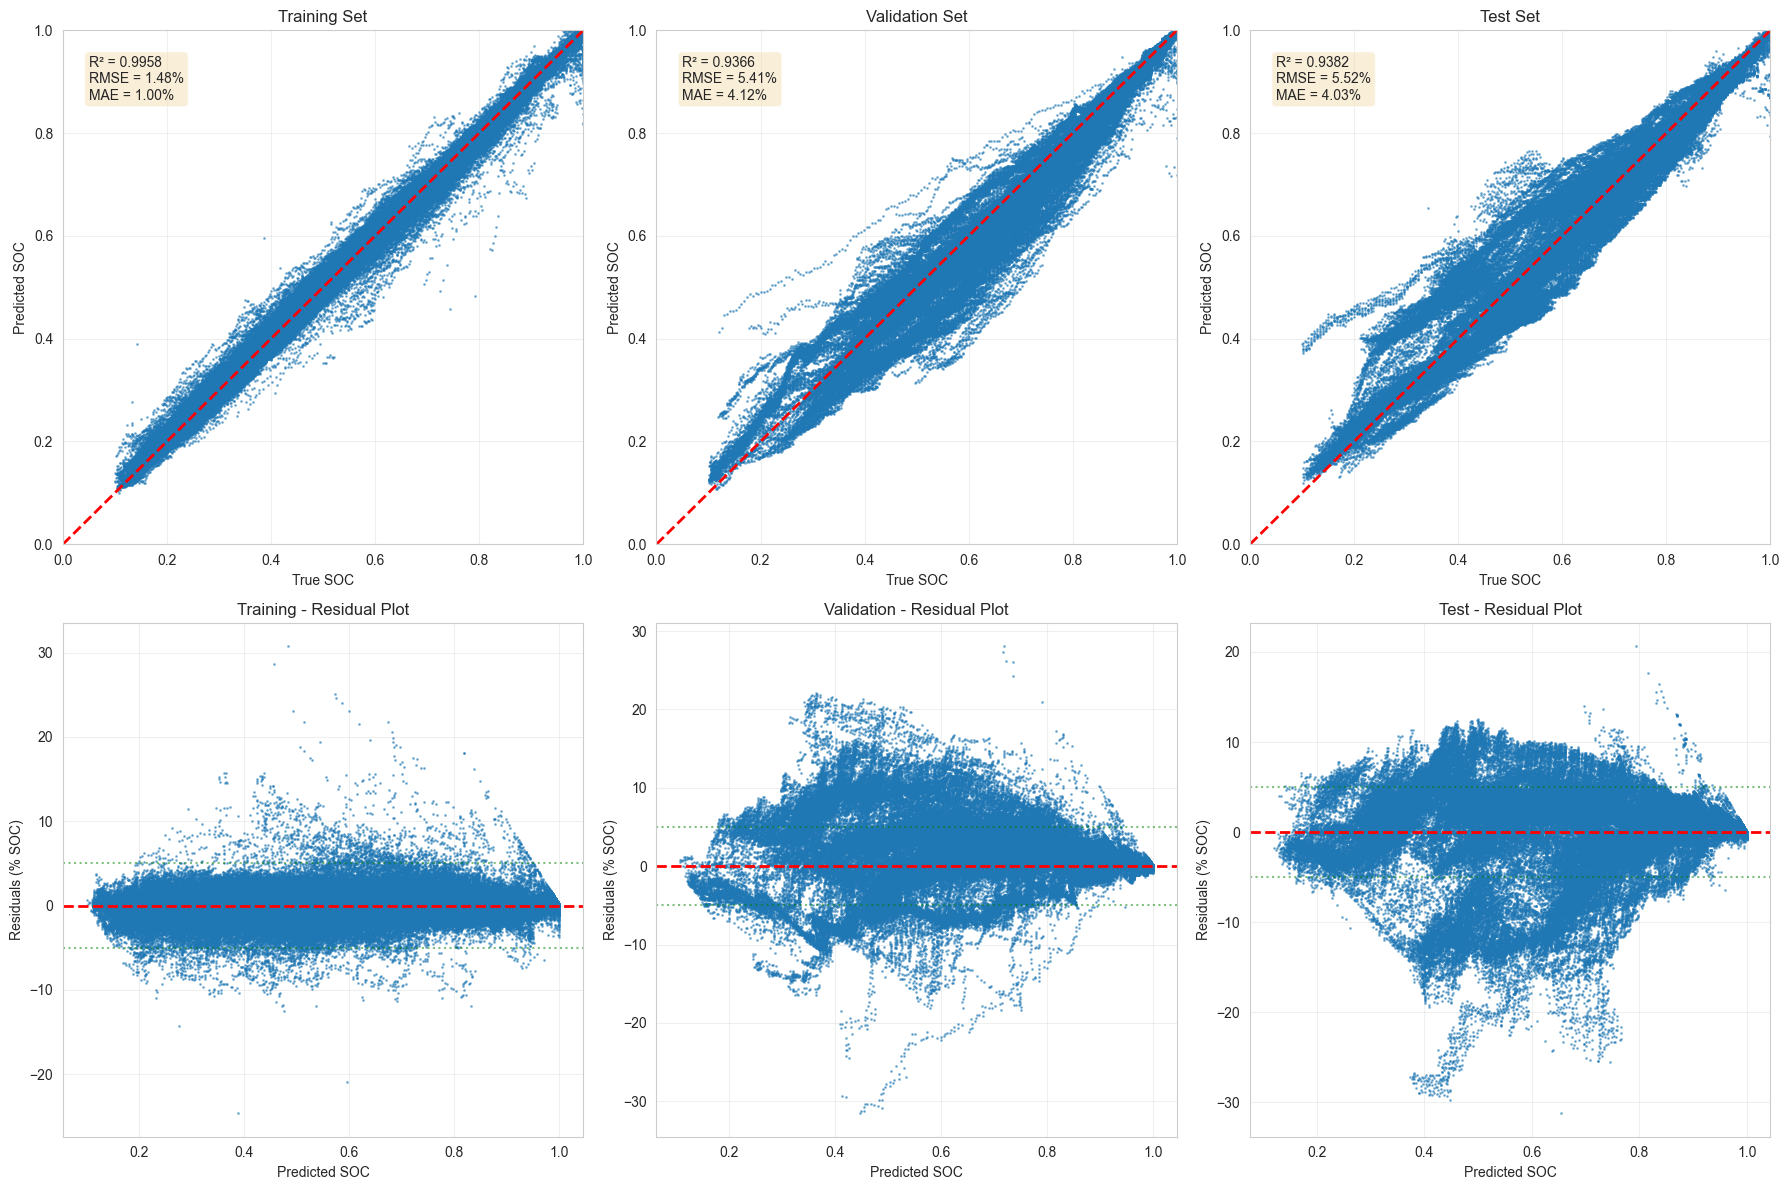

In [8]:
# Create visualization subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Function to plot predictions vs actual
def plot_predictions(ax, y_true, y_pred, title, metrics):
    ax.scatter(y_true, y_pred, alpha=0.5, s=1)
    ax.plot([0, 1], [0, 1], 'r--', lw=2)
    ax.set_xlabel('True SOC')
    ax.set_ylabel('Predicted SOC')
    ax.set_title(title)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3)
    
    # Add metrics text
    text_str = f"R² = {metrics['r2']:.4f}\nRMSE = {metrics['rmse']:.2f}%\nMAE = {metrics['mae']:.2f}%"
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot predictions for each set
plot_predictions(axes[0, 0], y_train, y_train_pred, 'Training Set', train_metrics)
plot_predictions(axes[0, 1], y_val, y_val_pred, 'Validation Set', val_metrics)
plot_predictions(axes[0, 2], y_test, y_test_pred, 'Test Set', test_metrics)

# Plot residuals
def plot_residuals(ax, y_true, y_pred, title):
    residuals = (y_true - y_pred) * 100  # Convert to percentage
    ax.scatter(y_pred, residuals, alpha=0.5, s=1)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_xlabel('Predicted SOC')
    ax.set_ylabel('Residuals (% SOC)')
    ax.set_title(f'{title} - Residual Plot')
    ax.grid(True, alpha=0.3)
    
    # Add ±5% bounds
    ax.axhline(y=5, color='g', linestyle=':', alpha=0.5)
    ax.axhline(y=-5, color='g', linestyle=':', alpha=0.5)

plot_residuals(axes[1, 0], y_train, y_train_pred, 'Training')
plot_residuals(axes[1, 1], y_val, y_val_pred, 'Validation')
plot_residuals(axes[1, 2], y_test, y_test_pred, 'Test')

plt.tight_layout()
plt.show()

## 9. Error Analysis by SOC Range

In [9]:
# Analyze errors by SOC range
def analyze_errors_by_range(y_true, y_pred, dataset_name):
    """Analyze prediction errors across different SOC ranges"""
    ranges = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1.0)]
    
    print(f"\n{dataset_name} Set - Error Analysis by SOC Range:")
    print("-" * 60)
    print(f"{'SOC Range':<15} {'Samples':<10} {'MAE (%)':<10} {'RMSE (%)':<10} {'R²':<10}")
    print("-" * 60)
    
    for low, high in ranges:
        mask = (y_true >= low) & (y_true < high)
        if np.sum(mask) > 0:
            y_true_range = y_true[mask]
            y_pred_range = y_pred[mask]
            
            mae = mean_absolute_error(y_true_range, y_pred_range) * 100
            rmse = np.sqrt(mean_squared_error(y_true_range, y_pred_range)) * 100
            r2 = r2_score(y_true_range, y_pred_range) if len(y_true_range) > 1 else 0
            
            print(f"{f'{low*100:.0f}-{high*100:.0f}%':<15} {np.sum(mask):<10} {mae:<10.3f} {rmse:<10.3f} {r2:<10.4f}")

# Analyze errors for test set
analyze_errors_by_range(y_test, y_test_pred, "Test")


Test Set - Error Analysis by SOC Range:
------------------------------------------------------------
SOC Range       Samples    MAE (%)    RMSE (%)   R²        
------------------------------------------------------------
0-20%           2251       4.262      7.578      -8.8451   
20-40%          18635      5.344      7.399      -0.8550   
40-60%          30374      5.624      6.883      -0.4333   
60-80%          30921      3.884      4.647      0.3500    
80-100%         30745      1.847      2.523      0.8064    


## 10. Training History Visualization

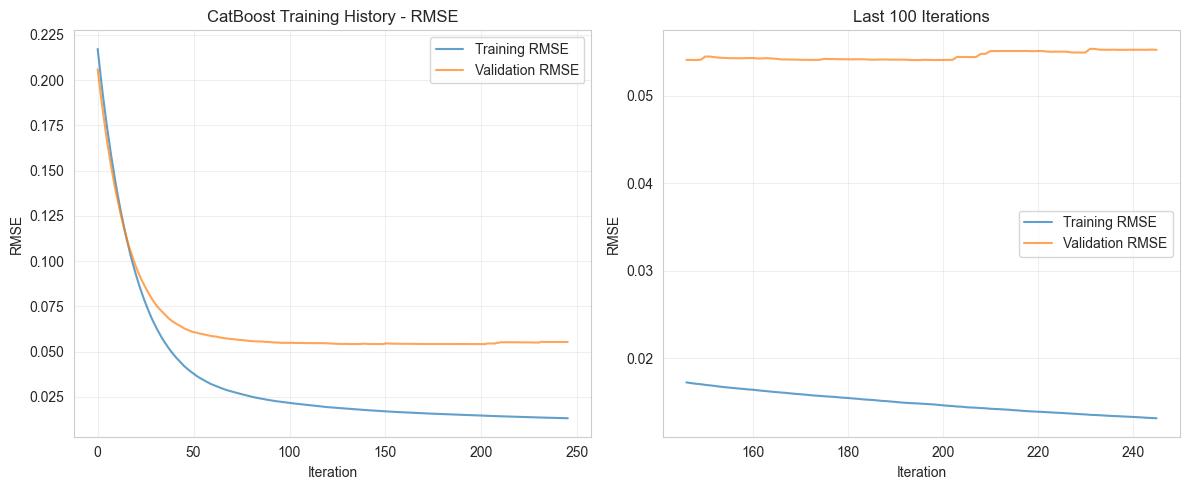


Training stopped at iteration 195
Final validation RMSE: 0.054090


In [10]:
# Get training history
evals_result = catboost_model.get_evals_result()

# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
iterations = range(len(evals_result['learn']['RMSE']))
plt.plot(iterations, evals_result['learn']['RMSE'], label='Training RMSE', alpha=0.7)
plt.plot(iterations, evals_result['validation']['RMSE'], label='Validation RMSE', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('CatBoost Training History - RMSE')
plt.legend()
plt.grid(True, alpha=0.3)

# Zoomed in view of last iterations
plt.subplot(1, 2, 2)
last_100 = min(100, len(iterations))
plt.plot(iterations[-last_100:], evals_result['learn']['RMSE'][-last_100:], 
         label='Training RMSE', alpha=0.7)
plt.plot(iterations[-last_100:], evals_result['validation']['RMSE'][-last_100:], 
         label='Validation RMSE', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title(f'Last {last_100} Iterations')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining stopped at iteration {catboost_model.best_iteration_}")
print(f"Final validation RMSE: {evals_result['validation']['RMSE'][catboost_model.best_iteration_]:.6f}")

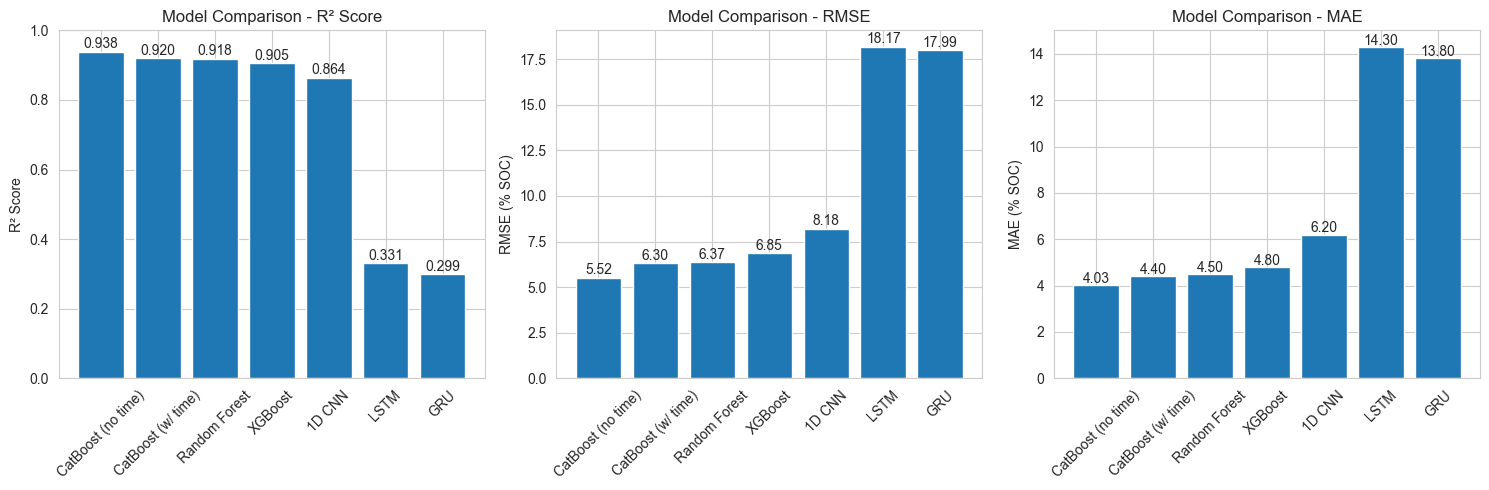


Model Performance Ranking:
             Model  Test R²  Test RMSE (%)  Test MAE (%)
CatBoost (no time) 0.938232       5.519784      4.034074
CatBoost (w/ time) 0.920000       6.300000      4.400000
     Random Forest 0.918000       6.370000      4.500000
           XGBoost 0.905000       6.850000      4.800000
            1D CNN 0.864000       8.180000      6.200000
              LSTM 0.331000      18.170000     14.300000
               GRU 0.299000      17.990000     13.800000


In [11]:
# Comparison with other models from notes
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', '1D CNN', 'LSTM', 'GRU', 'CatBoost (w/ time)', 'CatBoost (no time)'],
    'Test R²': [0.918, 0.905, 0.864, 0.331, 0.299, 0.92, test_metrics['r2']],  # Estimate for CatBoost w/ time
    'Test RMSE (%)': [6.37, 6.85, 8.18, 18.17, 17.99, 6.3, test_metrics['rmse']],
    'Test MAE (%)': [4.5, 4.8, 6.2, 14.3, 13.8, 4.4, test_metrics['mae']]
})

model_comparison = model_comparison.sort_values('Test R²', ascending=False)

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# R² comparison
axes[0].bar(model_comparison['Model'], model_comparison['Test R²'])
axes[0].set_ylabel('R² Score')
axes[0].set_title('Model Comparison - R² Score')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(model_comparison['Test R²']):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# RMSE comparison
axes[1].bar(model_comparison['Model'], model_comparison['Test RMSE (%)'])
axes[1].set_ylabel('RMSE (% SOC)')
axes[1].set_title('Model Comparison - RMSE')
axes[1].tick_params(axis='x', rotation=45)
for i, v in enumerate(model_comparison['Test RMSE (%)']):
    axes[1].text(i, v + 0.2, f'{v:.2f}', ha='center')

# MAE comparison
axes[2].bar(model_comparison['Model'], model_comparison['Test MAE (%)'])
axes[2].set_ylabel('MAE (% SOC)')
axes[2].set_title('Model Comparison - MAE')
axes[2].tick_params(axis='x', rotation=45)
for i, v in enumerate(model_comparison['Test MAE (%)']):
    axes[2].text(i, v + 0.1, f'{v:.2f}', ha='center')

plt.tight_layout()
plt.show()

print("\nModel Performance Ranking:")
print(model_comparison.to_string(index=False))

In [12]:
# Save the model with unique name
model_path = OUTPUT_DIR / 'catboost_notime_model.cbm'
catboost_model.save_model(str(model_path))
print(f"Model saved to: {model_path}")

# Save predictions and metrics
results = {
    'model': 'CatBoost_NoTime',
    'train_metrics': train_metrics,
    'val_metrics': val_metrics,
    'test_metrics': test_metrics,
    'y_train_pred': y_train_pred,
    'y_val_pred': y_val_pred,
    'y_test_pred': y_test_pred,
    'y_train_true': y_train,
    'y_val_true': y_val,
    'y_test_true': y_test,
    'best_iteration': catboost_model.best_iteration_,
    'feature_importance': feature_importance,
    'feature_names': feature_names,
    'kept_feature_names': kept_feature_names,
    'removed_features': {
        'leaking': leaking_features,
        'temporal': temporal_features
    }
}

# Save results with unique name
results_path = OUTPUT_DIR / 'catboost_notime_results.pkl'
with open(results_path, 'wb') as f:
    pickle.dump(results, f)
print(f"Results saved to: {results_path}")

Model saved to: processed_data/catboost_notime_model.cbm
Results saved to: processed_data/catboost_notime_results.pkl


## 13. Summary

In [13]:
print("="*60)
print("CATBOOST MODEL - PRODUCTION READY (STATISTICAL FEATURES ONLY)")
print("="*60)

print(f"\nBest Iteration: {catboost_model.best_iteration_}")
print(f"\nFinal Test Set Performance:")
print(f"  R² Score: {test_metrics['r2']:.4f}")
print(f"  RMSE: {test_metrics['rmse']:.3f}% SOC")
print(f"  MAE: {test_metrics['mae']:.3f}% SOC")

print("="*60)

CATBOOST MODEL - PRODUCTION READY (STATISTICAL FEATURES ONLY)

Best Iteration: 195

Final Test Set Performance:
  R² Score: 0.9382
  RMSE: 5.520% SOC
  MAE: 4.034% SOC
